#### For this problem set I worked with Eugene Leypunskiy

In [255]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
import string
from collections import Counter
import nltk
from nltk.corpus import stopwords
from itertools import permutations, product
import os
import cPickle
import scipy


### PMI Embeddings

In [4]:
wiki_file = open('/project/cmsc25025/wikipedia/wiki-text.txt','r').readlines()[0]
num_chunks = 28**3 #make it multiple of number of your cores
chunks, chunk_size = len(wiki_file), len(wiki_file)/num_chunks
wiki_chunks = [wiki_file[i:i+chunk_size] for i in range(0, chunks, chunk_size)]

spark = SparkSession.builder.master('local[*]')\
                            .appName('wiki')\
                            .config("spark.driver.maxResultSize", "20g")\
                            .config("spark.driver.memory", "20g")\
                            .config("spark.executor.memory", "20g")\
                            .getOrCreate()

wiki_data = spark.sparkContext.parallelize(wiki_chunks)

In [5]:
stopWords = set(stopwords.words('english'))
stopWords = [i for i in stopWords]


In [6]:
def get_rid_of_stopwords(countVar, stopWords):
    for i in stopWords:
        try:
            countVar.pop(i)
        except KeyError:
            continue
    return countVar
        

In [8]:
vocabulary = wiki_data.map(lambda x: x.split())\
                      .map(lambda x: Counter(x))\
                      .map(lambda x: get_rid_of_stopwords(x, stopWords))\
                      .reduce(lambda a,b: a + b)

In [9]:
vocabulary = Counter({k:v for k,v in vocabulary.items() if v > 500}).most_common()

In [10]:
masterVocabs, masterVocabCounts = zip(*vocabulary)
masterVocabs = list(masterVocabs)
masterVocabCounts = list(masterVocabCounts)

In [11]:
def make_word_context_tuples(text, masterVocabs):
    wordContextList = []
    for i,item in enumerate(text):
        for j in range(11):
            j = j - 5
            index = i + j
            if j == 0:
                continue
            if index < 0:
                continue
            else:                
                try:
                    if item not in masterVocabs:
                        continue
                    elif text[index] not in masterVocabs:
                        continue
                    wordContext = ((item,text[index]),1)
                    wordContextList.append(wordContext)
                except IndexError:
                    continue
    return wordContextList
        
    
    

### Part (a): calculating co-occurrance w-c pairs

In [16]:
co_occurance = wiki_data.map(lambda x: x.split())\
                        .flatMap(lambda x: make_word_context_tuples(x, masterVocabs))\
                        .reduceByKey(lambda a,b: a + b)
                

In [17]:
# This takes a long time

coOccuranceVector = co_occurance.collect()

In [225]:
# So let's save the vector
cPickle.dump(coOccuranceVector, open("coOccuranceVector.cp", "wb"))

In [18]:
coOccuranceCardinality = len(coOccuranceVector)
coOccuranceDict = dict(coOccuranceVector)

In [121]:
# Calculating the PMI matrix
pmiMatrix = []
for i, vocab1 in enumerate(masterVocabs):
    dumList1 = []
    for j, vocab2 in enumerate(masterVocabs):
        try:
            wiwjTuple1 = (vocab1, vocab2)
            wiwj = coOccuranceDict[wiwjTuple1]
            mij = np.log( (float(wiwj + 1.) * float(coOccuranceCardinality)) / \
                          (float(masterVocabCounts[i]) * float(masterVocabCounts[j])))
            dumList1.append(mij)
        except KeyError:
            wiwj = 0.
            mij = np.log( (float(wiwj + 1.) * float(coOccuranceCardinality)) / \
                          (float(masterVocabCounts[i]) * float(masterVocabCounts[j])))
            dumList1.append(mij)
    pmiMatrix.append(dumList1)

In [122]:
# Make the PMI Matrix a numpy array

pmiMatrix = np.array(pmiMatrix)

# cPickle it
cPickle.dump(np.array([pmiMatrix]), open("pmiMatrix.cp","wb"))

In [161]:
# Calculate SVD

U, s, V = scipy.sparse.linalg.svds(pmiMatrix, k=50)

In [171]:
# Calculate the W matrix
wMat = np.dot(np.array(U), np.power(np.diag(s), 1./2.))

In [256]:
# Save masterVocabCounts, masterVocabs and the W Matrix
cPickle.dump(masterVocabCounts, open("masterVocabCounts", "wb"))
cPickle.dump(masterVocabs, open("masterVocabs.cp", "wb"))
cPickle.dump(wMat, open("wMatrix.cp", "wb"))

# Part 4(a)


In [88]:
# Ran GloVe on midway to get wiki-vocab.txt and wiki-vectors.txt

vocab_file = 'GloVe/wiki-vocab.txt'
vectors_file = 'GloVe/wiki-vectors.txt'
with open(vocab_file, 'r') as f:
    words = [x.rstrip().split(' ')[0] for x in f.readlines()]
with open(vectors_file, 'r') as f:
    vectors = {}
    for line in f:
        vals = line.rstrip().split(' ')
        vectors[vals[0]] = [float(x) for x in vals[1:]]
        
vocab = {w: idx for idx, w in enumerate(words)}
ivocab = {idx: w for idx, w in enumerate(words)}

In [92]:
# What the embedding for umbrella looks like
vectors['umbrella']

[0.191622,
 0.185738,
 -0.385474,
 -0.164728,
 0.260358,
 1.104398,
 0.199163,
 0.42758,
 -0.382628,
 -0.330602,
 0.199798,
 -0.713433,
 -0.234381,
 -0.023849,
 0.285959,
 -0.417093,
 -0.092718,
 -0.180878,
 0.18382,
 0.957654,
 0.689498,
 0.606767,
 -0.636975,
 0.173281,
 0.342754,
 -0.407437,
 -0.806936,
 -0.07333,
 -0.253658,
 0.620119,
 -0.067735,
 -0.635934,
 -0.339229,
 -0.631078,
 -0.009188,
 -0.43046,
 -0.596538,
 -0.037606,
 0.589336,
 0.549375,
 0.235657,
 -0.170194,
 -0.629038,
 -0.431413,
 0.11747,
 0.525274,
 -0.009463,
 0.239448,
 0.04099,
 0.365289]

# Part 4(b)


In [183]:
# For calculating the closest word, I'll be using sum of squared residuals as the metric
# This function will input the word of interest and the trained vector dictionary
# Output will be a list of tuples (word, residual)

def find_closest_word(word, vectors):
    wordResidualTuples = []
    wordVector = np.array(vectors[str(word)])
    for i in vectors:
        if str(i) == str(word):
            continue
        else:
            residual = np.sum((np.array(vectors[i]) - wordVector)**2)
            dumTuple = (i,residual)
            wordResidualTuples.append(dumTuple)
    return wordResidualTuples

In [189]:
# For wiki-trained GloVe set
vocab_file = 'GloVe/wiki-vocab.txt'
vectors_file = 'GloVe/wiki-vectors.txt'
with open(vocab_file, 'r') as f:
    words = [x.rstrip().split(' ')[0] for x in f.readlines()]
with open(vectors_file, 'r') as f:
    vectors = {}
    for line in f:
        vals = line.rstrip().split(' ')
        vectors[vals[0]] = [float(x) for x in vals[1:]]
        
vocab = {w: idx for idx, w in enumerate(words)}
ivocab = {idx: w for idx, w in enumerate(words)}

print "wiki-trained GloVe Set"
print "5 Words closest to physics:", sorted(find_closest_word('physics', vectors), key=lambda x:x[1])[:5]
print "5 Words closest to republican:", sorted(find_closest_word('republican', vectors), key=lambda x:x[1])[:5]
print "5 Words closest to einstein:", sorted(find_closest_word('einstein', vectors), key=lambda x:x[1])[:5]
print "5 Words closest to algebra:", sorted(find_closest_word('algebra', vectors), key=lambda x:x[1])[:5]
print "5 Words closest to fish:", sorted(find_closest_word('fish', vectors), key=lambda x:x[1])[:5]


wiki-trained GloVe Set
5 Words closest to physics: [('chemistry', 9.7493157640570001), ('mechanics', 10.926648474568001), ('mathematics', 11.097804873045), ('science', 11.559853958538001), ('quantum', 11.657098561397)]
5 Words closest to republican: [('democrat', 8.2856738879080005), ('senator', 8.3159226078849997), ('representative', 10.264810741461), ('whig', 14.943647567914002), ('democrats', 15.338086140509999)]
5 Words closest to einstein: [('relativity', 8.3924615954669992), ('maxwell', 9.3176571034650006), ('bose', 12.554689919525002), ('formulated', 12.730174469029), ('relates', 13.088836364464001)]
5 Words closest to algebra: [('algebras', 11.362341108321999), ('algebraic', 12.352666160467001), ('finite', 12.897992383249003), ('multiplication', 15.038205047775998), ('boolean', 15.098257696927998)]
5 Words closest to fish: [('feed', 9.4157081901660025), ('hunting', 11.752659976588999), ('fresh', 12.180701047149), ('bird', 12.490164597435999), ('salmon', 12.639436100863)]


In [190]:
# For pre-trained GloVe set

vectors_file = 'GloVe/glove.6B.50d.txt'

with open(vectors_file, 'r') as f:
    vectors = {}
    for line in f:
        vals = line.rstrip().split(' ')
        vectors[vals[0]] = [float(x) for x in vals[1:]]
        
print "pre-trained GloVe Set"
print "5 Words closest to physics:", sorted(find_closest_word('physics', vectors), key=lambda x:x[1])[:5]
print "5 Words closest to republican:", sorted(find_closest_word('republican', vectors), key=lambda x:x[1])[:5]
print "5 Words closest to einstein:", sorted(find_closest_word('einstein', vectors), key=lambda x:x[1])[:5]
print "5 Words closest to algebra:", sorted(find_closest_word('algebra', vectors), key=lambda x:x[1])[:5]
print "5 Words closest to fish:", sorted(find_closest_word('fish', vectors), key=lambda x:x[1])[:5]

pre-trained GloVe Set
5 Words closest to physics: [('chemistry', 6.7559904588019997), ('mathematics', 8.2927871603994401), ('theoretical', 10.117731250196), ('science', 11.498446593279693), ('biology', 12.18883092894624)]
5 Words closest to republican: [('gop', 3.2180613688839999), ('democrat', 6.5256713819699987), ('democratic', 6.8798670593370002), ('republicans', 6.9998712715300009), ('democrats', 7.1647835604499992)]
5 Words closest to einstein: [('bohr', 12.331782862801891), ('relativity', 13.194435220753251), ('invented', 13.358021733103), ('freud', 13.65192518977476), ('gottlieb', 13.742802154982)]
5 Words closest to algebra: [('geometry', 14.005960469049212), ('homological', 16.946830072610211), ('algebraic', 17.247541109883411), ('associative', 17.730630687553415), ('analytic', 18.863681267272412)]
5 Words closest to fish: [('salmon', 9.845436410973571), ('shrimp', 12.980046370305372), ('meat', 13.248687542532569), ('bird', 13.563175814569568), ('wild', 13.711795213364434)]


In [191]:
# For PMI Embedding set

vectors = {}
for i in range(len(wMat)):
    vectors[masterVocabs[i]] = wMat[i]

print "PMI Embedding Set"
print "5 Words closest to physics:", sorted(find_closest_word('physics', vectors), key=lambda x:x[1])[:5]
print "5 Words closest to republican:", sorted(find_closest_word('republican', vectors), key=lambda x:x[1])[:5]
print "5 Words closest to einstein:", sorted(find_closest_word('einstein', vectors), key=lambda x:x[1])[:5]
print "5 Words closest to algebra:", sorted(find_closest_word('algebra', vectors), key=lambda x:x[1])[:5]
print "5 Words closest to fish:", sorted(find_closest_word('fish', vectors), key=lambda x:x[1])[:5]

PMI Embedding Set
5 Words closest to physics: [('mechanics', 1.8814189675199557), ('chemistry', 1.9798860739639306), ('quantum', 2.1829195572925015), ('mathematics', 2.2842540360565451), ('mathematical', 2.6082291783129374)]
5 Words closest to republican: [('senator', 1.6098700604002207), ('democrat', 1.6342500070534136), ('representative', 2.5541361292563658), ('democrats', 2.7024127301222265), ('candidate', 2.931239706363578)]
5 Words closest to einstein: [('relativity', 0.41794650119121945), ('paradox', 0.69473610063421221), ('maxwell', 0.7797152088885847), ('thesis', 0.8714555361643761), ('galileo', 0.95061625538847494)]
5 Words closest to algebra: [('algebraic', 0.52810908819007563), ('finite', 0.63136478549756514), ('theorem', 0.70716602247693672), ('equations', 0.91705211154669375), ('topology', 0.92368978319968598)]
5 Words closest to fish: [('fruit', 1.0377742952262106), ('meat', 1.5083024580696744), ('eggs', 1.7175448220733709), ('cattle', 1.7392827232077646), ('milk', 1.8796

### Comment
All the methodologies seems to produce some similar and different top 5 closest words in all cases. For example, for physics, wiki-glove found chemistry, mechanics, mathematics, science and quantum, pre-trained glove found chemistry, mathematics, theoretical, science, and biology, and PMI embedding found mechanics, chemistry, quantum, mathematics and mathematical. They all think chemistry and mathematics is quite related to each other, which makes sense because they are all different disciplines of sciences. However, at the same time, pre-trained glove is the only embedding with biology or theoretical listed as close to physics, and PMI embedding is the only one with mathematical in its list. This is quite similar in all other cases as well. 

# Part 4(c): Analogies

france: paris :: england : ?

In [257]:
# Defining a way to calculate analogies
# Find a vector closest to v_?
# where v_? = v_paris - v_france + v_england or word1Partner - word1 + word2

def calc_analogy(word1, word1Partner, word2, vectors):
    try:
        wordVector1 = np.array(vectors[str(word1)])
        wordVector2 = np.array(vectors[str(word1Partner)])
        wordVector3 = np.array(vectors[str(word2)])
        predictVector = wordVector2 - wordVector1 + wordVector3
        oldResidual = 100000
        for i in vectors:
            residual = np.sum((np.array(vectors[i]) - predictVector)**2)
            if str(i) == str(word1) or str(i) == str(word1Partner) or str(i) == str(word2):
                continue
            else: 
                if residual < oldResidual:
                    oldResidual = residual
                    newWord = i
        return oldResidual, newWord
    except KeyError:
        print "Not in vocabulary"

In [258]:
# For PMI Embedding set

vectors = {}
for i in range(len(wMat)):
    vectors[masterVocabs[i]] = wMat[i]

calc_analogy('france','paris','england', vectors)

(3.249535102434344, 'london')

In [259]:
# For pre-trained GloVe set

vectors_file = 'GloVe/glove.6B.50d.txt'

with open(vectors_file, 'r') as f:
    vectors = {}
    for line in f:
        vals = line.rstrip().split(' ')
        vectors[vals[0]] = [float(x) for x in vals[1:]]
calc_analogy('france','paris','england', vectors)

(10.436077275769854, 'melbourne')

In [260]:
# For wiki-trained GloVe set
vocab_file = 'GloVe/wiki-vocab.txt'
vectors_file = 'GloVe/wiki-vectors.txt'
with open(vocab_file, 'r') as f:
    words = [x.rstrip().split(' ')[0] for x in f.readlines()]
with open(vectors_file, 'r') as f:
    vectors = {}
    for line in f:
        vals = line.rstrip().split(' ')
        vectors[vals[0]] = [float(x) for x in vals[1:]]
        
vocab = {w: idx for idx, w in enumerate(words)}
ivocab = {idx: w for idx, w in enumerate(words)}
calc_analogy('france','paris','england', vectors)

(8.5177800589740009, 'london')

### Quick comment
Interestingly, the pre-trained GloVe did the worst in this case. While PMI and wiki-trained GloVe set got london right, pre-trained GloVe got melbourne.

# Part 4(c)

In [252]:
import glob
import re

# For PMI Embedding set

vectors = {}
for i in range(len(wMat)):
    vectors[masterVocabs[i]] = wMat[i]

fileList = glob.glob('/project/cmsc25025/assn4_analogy/*.txt')
for i in fileList:
    for lines in open(i,'r'):
        lines = lines.strip()
        wordList = re.split('\\s+|:|=|\n|', lines)
        try:
            word1 = wordList[0]
            word2 = wordList[1]
            word3 = wordList[2]
            calc_analogy(word1, word2, word3, vectors)
        except IndexError:
            continue

 Not in vocabulary
Not in vocabulary
Not in vocabulary
Not in vocabulary
Not in vocabulary
Not in vocabulary
Not in vocabulary
Not in vocabulary
Not in vocabulary
Not in vocabulary
Not in vocabulary
Not in vocabulary
Not in vocabulary
Not in vocabulary
Not in vocabulary
Not in vocabulary
Not in vocabulary
Not in vocabulary
Not in vocabulary
Not in vocabulary
Not in vocabulary
Not in vocabulary
Not in vocabulary
Not in vocabulary
Not in vocabulary
Not in vocabulary
Not in vocabulary
Not in vocabulary
Not in vocabulary
Not in vocabulary
Not in vocabulary
Not in vocabulary
Not in vocabulary
Not in vocabulary
Not in vocabulary
Not in vocabulary
Not in vocabulary
Not in vocabulary
Not in vocabulary
Not in vocabulary
Not in vocabulary
Not in vocabulary
Not in vocabulary
Not in vocabulary
Not in vocabulary
Not in vocabulary
Not in vocabulary
Not in vocabulary
Not in vocabulary
Not in vocabulary
Not in vocabulary
Not in vocabulary
Not in vocabulary
Not in vocabulary
Not in vocabulary
Not in vo

In [262]:
#For Pre-trained GloVE
vectors_file = 'GloVe/glove.6B.50d.txt'

with open(vectors_file, 'r') as f:
    vectors = {}
    for line in f:
        vals = line.rstrip().split(' ')
        vectors[vals[0]] = [float(x) for x in vals[1:]]
        
fileList = glob.glob('/project/cmsc25025/assn4_analogy/*.txt')
for i in fileList:
    for lines in open(i,'r'):
        lines = lines.strip()
        wordList = re.split('\\s+|:|=|\n|', lines)
        try:
            word1 = wordList[0]
            word2 = wordList[1]
            word3 = wordList[2]
            print "%s:%s=%s:" % (word1, word2, word3), calc_analogy(word1, word2, word3, vectors)
        except IndexError:
            continue

 segregate:unify=damage: (22.216023051273886, 'overcome')
argentina:brazil=iran: (17.45820330496753, 'tehran')
ashes:urn=money: (15.991992414665587, 'cash')
telephone:cord=television: (23.812014655449428, 'spinal')
walk:roam=speak: (20.73361020644877, 'outsiders')
novel:epilogue=meal: (16.754448878290621, 'multicourse')
chinese:china=french: (3.1089572398459948, 'france')
evening:morning=dinner: (6.5518783570198895, 'lunch')
left:right=horizontal: (16.007326117333001, 'vertical')
theorem:deduce=hypothesis: (18.106161431570616, 'clinicians')
h:water=bird: (42.836569689659967, 'fish')
chicken:egg=cow: (19.708530170798184, 'cloned')
go:green=stop: (14.861276011043564, 'yellow')
chicago:illinois=dallas: (5.1776843175535028, 'ohio')
library:book=resturant: Not in vocabulary
None
dessert:meal=revelations: (17.90691484338863, 'abuse')
chef:knife=student: (39.482594385490856, 'gun')
cookies:milk=chips: (21.784270905250999, 'consumption')
math:physics=calculus: (29.429075595307182, 'relativity'

In [263]:
# For wiki-trained GloVe set
vocab_file = 'GloVe/wiki-vocab.txt'
vectors_file = 'GloVe/wiki-vectors.txt'
with open(vocab_file, 'r') as f:
    words = [x.rstrip().split(' ')[0] for x in f.readlines()]
with open(vectors_file, 'r') as f:
    vectors = {}
    for line in f:
        vals = line.rstrip().split(' ')
        vectors[vals[0]] = [float(x) for x in vals[1:]]

fileList = glob.glob('/project/cmsc25025/assn4_analogy/*.txt')
for i in fileList:
    for lines in open(i,'r'):
        lines = lines.strip()
        wordList = re.split('\\s+|:|=|\n|', lines)
        try:
            word1 = wordList[0]
            word2 = wordList[1]
            word3 = wordList[2]
            print "%s:%s=%s:" % (word1, word2, word3), calc_analogy(word1, word2, word3, vectors)
        except IndexError:
            continue

segregate:unify=damage: Not in vocabulary
None
argentina:brazil=iran: (12.481233426906, 'pakistan')
ashes:urn=money: (17.897226898940996, 'gift')
telephone:cord=television: (27.990478267321006, 'starred')
walk:roam=speak: (24.912176597150999, 'pakistanis')
novel:epilogue=meal: (27.269514285765005, 'meals')
chinese:china=french: (8.0161522676669996, 'france')
evening:morning=dinner: (8.9159369607800016, 'lunch')
left:right=horizontal: (10.839459601949001, 'vertical')
theorem:deduce=hypothesis: (18.417008727633998, 'anticipate')
h:water=bird: (38.709419627384001, 'fresh')
chicken:egg=cow: (16.184230683614999, 'wreck')
go:green=stop: (13.619416007029999, 'red')
chicago:illinois=dallas: (11.265640445845001, 'iowa')
library:book=resturant: Not in vocabulary
None
dessert:meal=revelations: (23.724251426663997, 'prophecy')
chef:knife=student: (18.557168143024999, 'students')
cookies:milk=chips: (18.48991522399, 'sugar')
math:physics=calculus: (18.092897097425002, 'mechanics')
marvel:dc=captain

## Comment
It seems like the PMI Embedding somehow lacks lot of the vocabularies used in the posted analogies. PMI embeddings couldn't get any of the analogies because it couldn't find at least one of the words used in the analogies. However, for wiki- and pre-trained GloVe, the methodologies do decently well in predicting the right word. For example, an easy one like boy:girl=man:woman. However, on some of the harder analogies, both seem to fail. For pre-trained, walk:roam=speak: (20.73361020644877, 'outsiders') and for wiki-trained, walk:roam=speak: (24.912176597150999, 'pakistanis'). Regardless, it is quite impressive that they can get the right words in many cases!

# Part 4(d)

In [278]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib notebook
# For pre-trained GloVe set

vectors_file = 'GloVe/glove.6B.50d.txt'

with open(vectors_file, 'r') as f:
    vectors = []
    words = []
    for line in f:
        vals = line.rstrip().split(' ')
        words.append(str(vals[0]))
        vectors.append([float(x) for x in vals[1:]])

In [279]:
vectors = np.array(vectors)
for label, x, y in zip(words[:1000], Y[:, 0], Y[:, 1]):
    print label, x, y
    break

the -4.65691470989 -9.07526740308


<IPython.core.display.Javascript object>


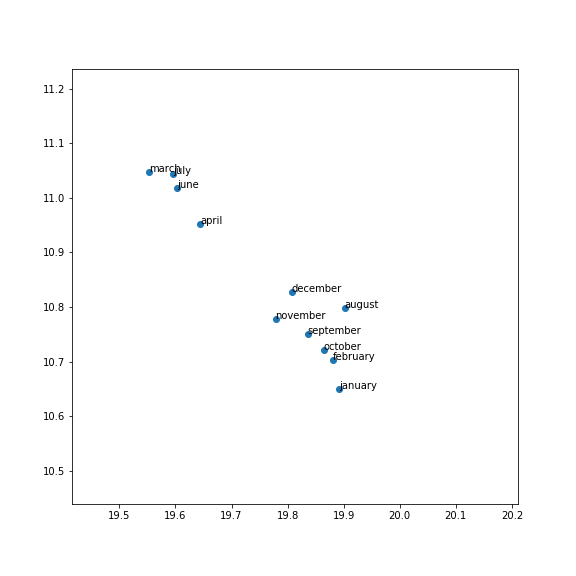

In [284]:
tsne = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
Y = tsne.fit_transform(vectors[:1000,:])
plt.figure(figsize=(8,8))
plt.scatter(Y[:, 0], Y[:, 1])
for label, x, y in zip(words[:1000], Y[:, 0], Y[:, 1]):
    plt.annotate(label.decode('utf-8'), xy=(x, y), xytext=(0, 0), textcoords='offset points', fontsize=10)
plt.show()

### Comment

I found a cluster of the months in a year.